# Training Recurrent Neural Networks: Integrator Task

This tutorial demonstrates how to train a recurrent neural network (RNN) to perform an **integration task** - a fundamental computation in neuroscience where networks must accumulate evidence over time.

## Learning Objectives

By the end of this tutorial, you will:
- Understand the integration task and its importance
- Build custom RNN cells in BrainState
- Train RNNs on temporal tasks
- Use trainable initial states
- Apply L2 regularization to prevent overfitting
- Visualize RNN predictions on time-series data

## The Integration Task

**Goal**: Given a noisy input signal, the network must compute the cumulative sum (integral) over time.

```
Input:  [x₁, x₂, x₃, ...]
Output: [x₁, x₁+x₂, x₁+x₂+x₃, ...]
```

This task requires:
- **Memory**: Remember past inputs
- **Accumulation**: Continuously integrate information
- **Robustness**: Handle noise in inputs

**Applications**:
- Evidence accumulation in decision-making
- Position estimation from velocity
- Financial modeling (cumulative returns)
- Signal processing

## Setup and Imports

In [5]:
from typing import Callable

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import brainstate
import braintools

# Set random seeds
np.random.seed(42)
brainstate.random.seed(42)

## Configuration

In [6]:
# Task parameters
dt = 0.04              # Time step
num_step = int(1.0 / dt)  # Steps per trial (25 steps for 1.0 time unit)
num_batch = 512        # Batch size

# Network parameters
num_hidden = 100       # Hidden units in RNN

# Training parameters
learning_rate = 0.025
lr_decay_rate = 0.99975
l2_reg = 2e-4
num_epochs = 5
batches_per_epoch = 500

print(f"Configuration:")
print(f"  Sequence length: {num_step} steps")
print(f"  Batch size: {num_batch}")
print(f"  Hidden units: {num_hidden}")
print(f"  Training batches: {num_epochs * batches_per_epoch}")

Configuration:
  Sequence length: 25 steps
  Batch size: 512
  Hidden units: 100
  Training batches: 2500


## Generate Data

### Data Generation Function

We'll create random walk inputs and compute their cumulative sums as targets:

In [7]:
@brainstate.transform.jit(static_argnums=2)
def build_inputs_and_targets(mean=0.025, scale=0.01, batch_size=10):
    """Generate integration task data.
    
    Args:
        mean: Mean of the random walk bias
        scale: Standard deviation of noise
        batch_size: Number of sequences
        
    Returns:
        inputs: [num_step, batch_size, 1] - Input sequences
        targets: [num_step, batch_size, 1] - Target cumulative sums
    """
    # Create initial bias
    sample = brainstate.random.normal(size=(1, batch_size, 1))
    bias = mean * 2.0 * (sample - 0.5)
    
    # Generate white noise
    samples = brainstate.random.normal(size=(num_step, batch_size, 1))
    noise_t = scale / dt ** 0.5 * samples
    
    # Inputs = bias + noise
    inputs = bias + noise_t
    
    # Targets = cumulative sum of inputs
    targets = jnp.cumsum(inputs, axis=0)
    
    return inputs, targets


def train_data():
    """Generator for training data."""
    for _ in range(batches_per_epoch * num_epochs):
        yield build_inputs_and_targets(0.025, 0.01, num_batch)

### Visualize Sample Data

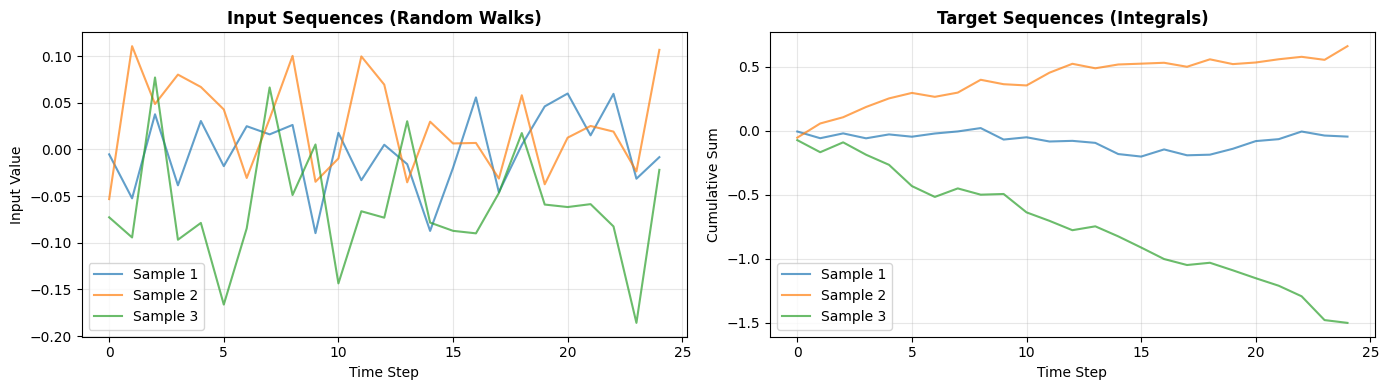

In [8]:
# Generate one batch for visualization
sample_inputs, sample_targets = build_inputs_and_targets(0.025, 0.01, 3)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot inputs
for i in range(3):
    axes[0].plot(sample_inputs[:, i, 0], alpha=0.7, label=f'Sample {i+1}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Input Value')
axes[0].set_title('Input Sequences (Random Walks)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot targets
for i in range(3):
    axes[1].plot(sample_targets[:, i, 0], alpha=0.7, label=f'Sample {i+1}')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Sum')
axes[1].set_title('Target Sequences (Integrals)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Building the RNN

### Custom RNN Cell

We'll create a vanilla RNN cell with optional trainable initial state:

In [9]:
class RNNCell(brainstate.nn.Module):
    """Vanilla RNN cell with trainable weights.
    
    h_t = activation(W_combined @ [x_t; h_{t-1}] + b)
    """
    
    def __init__(
        self,
        num_in: int,
        num_out: int,
        state_initializer: Callable = braintools.init.ZeroInit(),
        w_initializer: Callable = braintools.init.XavierNormal(),
        b_initializer: Callable = braintools.init.ZeroInit(),
        activation: Callable = brainstate.nn.relu,
        train_state: bool = False,  # Whether to train initial state
    ):
        super().__init__()
        
        self.num_out = num_out
        self.train_state = train_state
        
        # Activation function
        self.activation = activation
        
        # Combined weight matrix [input; hidden] -> hidden
        W = braintools.init.param(
            w_initializer, 
            (num_in + num_out, num_out)
        )
        b = braintools.init.param(b_initializer, (num_out,))
        
        self.W = brainstate.ParamState(W)
        self.b = brainstate.ParamState(b) if b is not None else None
        
        # Trainable initial state (optional)
        if train_state:
            self.state2train = brainstate.ParamState(
                braintools.init.ZeroInit()(num_out)
            )
        
        self._state_initializer = state_initializer
    
    def init_state(self, batch_size=None, **kwargs):
        """Initialize hidden state."""
        self.state = brainstate.HiddenState(
            braintools.init.param(
                self._state_initializer, 
                (self.num_out,), 
                batch_size
            )
        )
        
        # Use trainable initial state if specified
        if self.train_state:
            self.state.value = jnp.repeat(
                jnp.expand_dims(self.state2train.value, axis=0), 
                batch_size, 
                axis=0
            )
    
    def update(self, x):
        """Update RNN cell for one time step.
        
        Args:
            x: Input [batch, input_dim]
            
        Returns:
            h: New hidden state [batch, hidden_dim]
        """
        # Concatenate input and previous hidden state
        x_combined = jnp.concatenate([x, self.state.value], axis=-1)
        
        # Linear transformation
        h = x_combined @ self.W.value
        if self.b is not None:
            h += self.b.value
        
        # Apply activation
        h = self.activation(h)
        
        # Update state
        self.state.value = h
        
        return h

### Complete RNN Network

In [10]:
class RNN(brainstate.nn.Module):
    """RNN with recurrent layer and linear output."""
    
    def __init__(self, num_in, num_hidden):
        super().__init__()
        
        # RNN layer with trainable initial state
        self.rnn = RNNCell(num_in, num_hidden, train_state=True)
        
        # Output projection
        self.out = brainstate.nn.Linear(num_hidden, 1)
    
    def update(self, x):
        """Process one time step.
        
        Args:
            x: Input at current time step
            
        Returns:
            output: Prediction at current time step
        """
        # RNN forward pass using >> operator (pipe)
        return x >> self.rnn >> self.out

### Create Model and Optimizer

In [11]:
# Create RNN model
model = RNN(num_in=1, num_hidden=num_hidden)

# Get trainable parameters
weights = model.states(brainstate.ParamState)

# Create optimizer with learning rate decay
lr_schedule = braintools.optim.ExponentialDecayLR(
    learning_rate,
    decay_steps=1, 
    decay_rate=lr_decay_rate
)
optimizer = braintools.optim.Adam(lr=lr_schedule, eps=1e-1)
optimizer.register_trainable_weights(weights)

brainstate.nn.count_parameters(model)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
|   ('out', 'weight')    |    101     |
|      ('rnn', 'W')      |   10.10K   |
|      ('rnn', 'b')      |    100     |
| ('rnn', 'state2train') |    100     |
|         Total          |   10.40K   |
+------------------------+------------+


10401

## Training the RNN

### Define Prediction and Loss Functions

In [12]:
@brainstate.transform.jit
def f_predict(inputs):
    """Make predictions for a sequence.
    
    Args:
        inputs: [num_steps, batch_size, 1]
        
    Returns:
        predictions: [num_steps, batch_size, 1]
    """
    # Initialize RNN state
    brainstate.nn.init_all_states(model, batch_size=inputs.shape[1])
    
    # Process sequence
    return brainstate.transform.for_loop(model.update, inputs)


def f_loss(inputs, targets, l2_reg=2e-4):
    """Compute loss with L2 regularization.
    
    Args:
        inputs: Input sequences
        targets: Target sequences
        l2_reg: L2 regularization coefficient
        
    Returns:
        loss: Total loss value
    """
    # Get predictions
    predictions = f_predict(inputs)
    
    # Mean squared error
    mse = braintools.metric.squared_error(predictions, targets).mean()
    
    # L2 regularization on weights
    l2 = 0.0
    for weight in weights.values():
        for leaf in jax.tree.leaves(weight.value):
            l2 += jnp.sum(leaf ** 2)
    
    return mse + l2_reg * l2

### Define Training Step

In [13]:
@brainstate.transform.jit
def f_train(inputs, targets):
    """Perform one training step.
    
    Args:
        inputs: Input sequences
        targets: Target sequences
        
    Returns:
        loss: Loss value
    """
    # Compute gradients
    grads, loss = brainstate.transform.grad(
        f_loss, 
        weights, 
        return_value=True
    )(inputs, targets)
    
    # Update parameters
    optimizer.update(grads)
    
    return loss

### Run Training Loop

In [14]:
print("Starting training...\n")

for i_epoch in range(num_epochs):
    epoch_losses = []
    
    for i_batch, (inputs, targets) in enumerate(train_data()):
        if i_batch >= batches_per_epoch:
            break
        
        loss = f_train(inputs, targets)
        epoch_losses.append(float(loss))
        
        if (i_batch + 1) % 100 == 0:
            avg_loss = np.mean(epoch_losses[-100:])
            print(f'Epoch {i_epoch}, Batch {i_batch + 1:3d}, Loss {avg_loss:.5f}')
    
    avg_epoch_loss = np.mean(epoch_losses)
    print(f'\nEpoch {i_epoch} completed: Avg Loss = {avg_epoch_loss:.5f}\n')

print("Training complete!")

Starting training...

Epoch 0, Batch 100, Loss 0.19316
Epoch 0, Batch 200, Loss 0.02372
Epoch 0, Batch 300, Loss 0.02119
Epoch 0, Batch 400, Loss 0.02136
Epoch 0, Batch 500, Loss 0.04400

Epoch 0 completed: Avg Loss = 0.06069

Epoch 1, Batch 100, Loss 0.02979
Epoch 1, Batch 200, Loss 0.01970
Epoch 1, Batch 300, Loss 0.01925
Epoch 1, Batch 400, Loss 0.01887
Epoch 1, Batch 500, Loss 0.01854

Epoch 1 completed: Avg Loss = 0.02123

Epoch 2, Batch 100, Loss 0.01823
Epoch 2, Batch 200, Loss 0.01819
Epoch 2, Batch 300, Loss 0.01765
Epoch 2, Batch 400, Loss 0.01752
Epoch 2, Batch 500, Loss 0.01741

Epoch 2 completed: Avg Loss = 0.01780

Epoch 3, Batch 100, Loss 0.01673
Epoch 3, Batch 200, Loss 0.01644
Epoch 3, Batch 300, Loss 0.01648
Epoch 3, Batch 400, Loss 0.01619
Epoch 3, Batch 500, Loss 0.01601

Epoch 3 completed: Avg Loss = 0.01637

Epoch 4, Batch 100, Loss 0.01526
Epoch 4, Batch 200, Loss 0.09099
Epoch 4, Batch 300, Loss 0.03909
Epoch 4, Batch 400, Loss 0.01513
Epoch 4, Batch 500, Loss 0

## Evaluation and Visualization

### Test on New Data

In [15]:
# Generate test data
brainstate.nn.init_all_states(model, 1)
x_test, y_test = build_inputs_and_targets(0.025, 0.01, 1)
predictions = f_predict(x_test)

print(f"Test data generated:")
print(f"  Input shape: {x_test.shape}")
print(f"  Target shape: {y_test.shape}")
print(f"  Prediction shape: {predictions.shape}")

Test data generated:
  Input shape: (25, 1, 1)
  Target shape: (25, 1, 1)
  Prediction shape: (25, 1, 1)


### Plot Predictions vs. Ground Truth

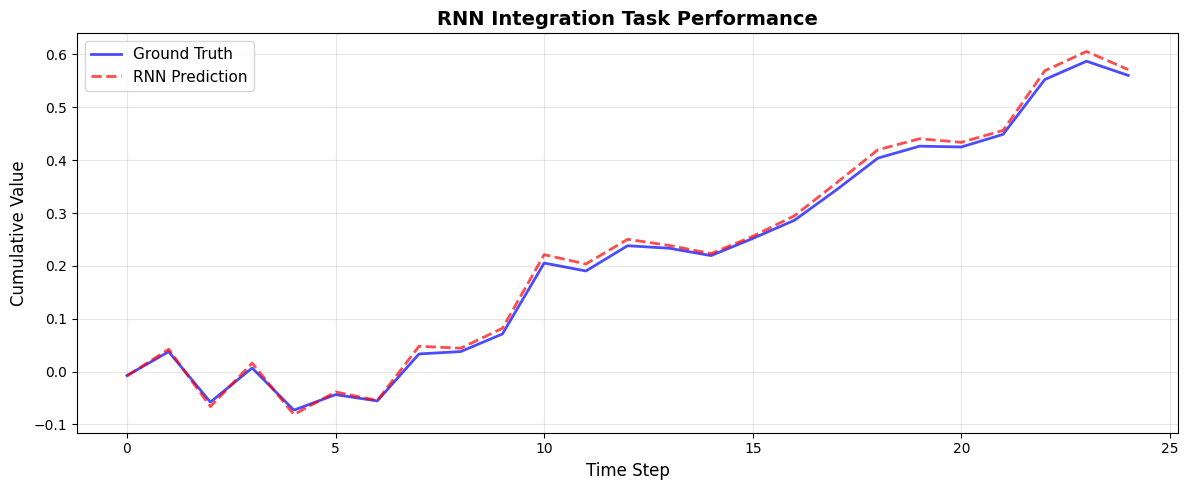


Test MSE: 0.000113


In [16]:
plt.figure(figsize=(12, 5))

# Convert to numpy for plotting
y_true = np.asarray(y_test[:, 0]).flatten()
y_pred = np.asarray(predictions[:, 0]).flatten()
time_steps = np.arange(len(y_true))

# Plot ground truth and predictions
plt.plot(time_steps, y_true, 'b-', linewidth=2, label='Ground Truth', alpha=0.7)
plt.plot(time_steps, y_pred, 'r--', linewidth=2, label='RNN Prediction', alpha=0.7)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative Value', fontsize=12)
plt.title('RNN Integration Task Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute final error
mse = np.mean((y_true - y_pred) ** 2)
print(f"\nTest MSE: {mse:.6f}")